In [1]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages')
#sys.path.append('/usr/local/lib/python3.7')


In [2]:
import pandas as pd
import scanpy.api as sc
import os
import time
import numpy as np
import igraph
from datetime import date

sc.settings.figdir = str(date.today()) + ' '
sc.settings.writedir = str(date.today()) + ' '
sc.settings.datasetdir = str(date.today()) + ' '




/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [3]:
samp_type = 'b16'
load_dir = os.getcwd() +'/' + samp_type+'_matrix_cells_as_rows.csv'
adata = sc.read(load_dir)
print(adata)

AnnData object with n_obs × n_vars = 105000 × 27933 


In [4]:
adata.obs_names_make_unique()
adata.var_names_make_unique()
sample_nums = pd.read_csv(os.getcwd()+'/'+samp_type+'_CELLSAMPLEMAP.csv',header=-1,index_col = 0,names=['sample'])
#print(sample_nums)
#for ele in sample_nums:
#    print(ele)
#    time.sleep(10000)
#time.sleep(10000)
adata.obs['sample_num'] = sample_nums['sample']
print(adata)

AnnData object with n_obs × n_vars = 105000 × 27933 
    obs: 'sample_num'


In [5]:

adata = adata[adata.obs['sample_num'].isin(['1','2','5','6','7','8','10','11','12','13','14','15','16','17','18','19','20','21'])]

malignant_cells = list(pd.read_csv(os.getcwd()+ '/malignant_cells.txt'))
adata = adata[~adata.obs_names.isin(malignant_cells)]

unknown_cells = list(pd.read_csv(os.getcwd()+ '/unknown cells.txt'))
adata = adata[~adata.obs_names.isin(unknown_cells)]

print(adata)

View of AnnData object with n_obs × n_vars = 88052 × 27933 
    obs: 'sample_num'


In [6]:

#Meromit's recomended num
sc.pp.filter_cells(adata, min_genes=400)
print(adata)
cap = int( len(adata.obs_names) * .01 )
print(cap)
#set min_cells to 1% of remaining data
sc.pp.filter_genes(adata, min_cells=cap)
print(adata)

Trying to set attribute `.obs` of view, making a copy.


AnnData object with n_obs × n_vars = 31467 × 27933 
    obs: 'sample_num', 'n_genes'
314
AnnData object with n_obs × n_vars = 31467 × 10363 
    obs: 'sample_num', 'n_genes'
    var: 'n_cells'


In [7]:
## housekeeping gene filtering ##

#general strategy was:
# - import gene list from text file
# - do the same boolean thing from above
# - use the adata[:,hk_genes_bool_list] slicing to call to a function that counts
# - make another list of just the total number of hk genes
# - divided across the lists
# - append that final list as an annotation
gene_path = os.getcwd() + '/HousekeepingGenes.txt'
master_gene_list = []
with open(gene_path, "r") as genes:
    lines = genes.readlines()
    if len(lines) == 1:
        with open(gene_path, "r") as genes:
            init_read = genes.read().splitlines()
            master_str = str.upper(init_read[0])
            master_gene_list = master_str.split(",")

#print(master_gene_list)
hk_genes = []
for gene in adata.var_names:
    if str.upper(gene) in master_gene_list:
        hk_genes.append(True)
    else:
        hk_genes.append(False)       
hk_genes_bool = np.asarray(hk_genes)
total = np.shape(adata[:,hk_genes_bool])[1]
#print(total)
#print(counter(adata[:,hk_genes_bool]))
def counter(data):
    count_list = []
    for cell in data:
        #print(cell)
        count = 0
        for counts in cell:
            #print(counts)
            if counts == 0:
                pass
            else:
                count = count + 1
        count_list.append(count)
    total_list = []
    for x in count_list:
        total_list.append(total)
    out_list = [x/y for x, y in zip(count_list,total_list)]
    return out_list

adata.obs['hk_count'] = counter(adata[:,hk_genes_bool].X)
#print(adata.obs['hk_count'])
print(adata)


##ACTUALLY FILTER##

adata = adata[adata.obs['hk_count'] > 0.5, :]

print(adata)


AnnData object with n_obs × n_vars = 31467 × 10363 
    obs: 'sample_num', 'n_genes', 'hk_count'
    var: 'n_cells'
View of AnnData object with n_obs × n_vars = 30654 × 10363 
    obs: 'sample_num', 'n_genes', 'hk_count'
    var: 'n_cells'


In [8]:
###Filtering cells with too much mitochondrial gene expression###


#Boolean list 
mito_genes = adata.var_names.str.startswith('mt-')
#print(type(mito_genes))
#print(mito_genes)
# for each cell compute fraction of counts in mito genes vs. all genes
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)
#How much is too much? Scanpy tutorial default below
#adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]
print(adata)

Trying to set attribute `.obs` of view, making a copy.


View of AnnData object with n_obs × n_vars = 29186 × 10363 
    obs: 'sample_num', 'n_genes', 'hk_count', 'percent_mito', 'n_counts'
    var: 'n_cells'


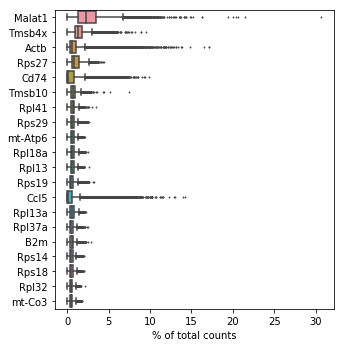

Trying to set attribute `.obs` of view, making a copy.


In [9]:
sc.pl.highest_expr_genes(adata, n_top=20)
adata.obs['unique_gene_count'] = np.count_nonzero(adata[:, adata.var_names].X, axis=1)

In [10]:
# gotta make a copy for counts data
adata_counts = adata.copy()
print(adata)
print(adata_counts)

AnnData object with n_obs × n_vars = 29186 × 10363 
    obs: 'sample_num', 'n_genes', 'hk_count', 'percent_mito', 'n_counts', 'unique_gene_count'
    var: 'n_cells'
AnnData object with n_obs × n_vars = 29186 × 10363 
    obs: 'sample_num', 'n_genes', 'hk_count', 'percent_mito', 'n_counts', 'unique_gene_count'
    var: 'n_cells'


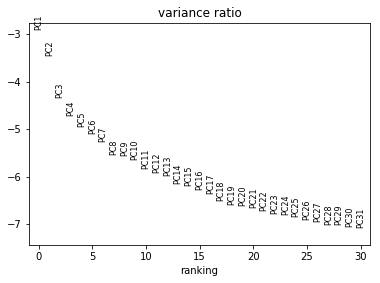

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [11]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs = 40)
sc.tl.umap(adata)

In [12]:
#sc.pl.umap(adata,color=['sample_num'],title='Sample',save='UMAP_SCANPY.pdf')
time_point = []
for sample_n in adata.obs['sample_num']:
    if sample_n == '1' or sample_n == '2' or sample_n == '3' or sample_n == '4':
        time_point.append('9')
    elif sample_n == '5' or sample_n == '6' or sample_n == '7' or sample_n == '8' or sample_n == '9':
        time_point.append('11')
    elif sample_n == '10' or sample_n == '11' or sample_n == '12' or sample_n == '13':
        time_point.append('12')
    elif sample_n == '14' or sample_n == '15' or sample_n == '16' or sample_n == '17':
        time_point.append('13')
    elif sample_n == '18' or sample_n == '19' or sample_n == '20' or sample_n == '21':
        time_point.append('16')
adata.obs['time_point'] = time_point
        
    

... storing 'sample_num' as categorical
... storing 'time_point' as categorical


saving figure to file 2020-04-09 /umapOverall_Umap.pdf


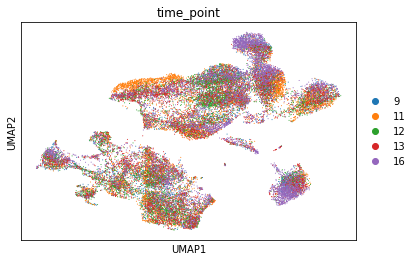

In [13]:
sc.pl.umap(adata,color='time_point',save='Overall_Umap.pdf')

In [14]:
import scrublet as scrubadubdub
import scipy
#print(mat)

#loop over existing adata structure to run scrublet for each mouse, appending the values as an observation
# makes all 21 lists of vals, adds together, then raw appends to the adata object
print(adata)

# make the full 21 sized list of np arrays with scores
all_doublets = []
for maus in sorted([int(x) for x in list(set(adata_counts.obs['sample_num']))]):
    counts_mat = adata_counts[adata_counts.obs['sample_num'].isin([str(maus)])]

    df = pd.DataFrame(index=counts_mat.obs_names,columns=counts_mat.var_names,data=counts_mat.X)
    #print(df)
    scrub_mat = df.as_matrix()
    scrub = scrubadubdub.Scrublet(scrub_mat)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    print(counts_mat)

    print(len(predicted_doublets))
    print('')
    all_doublets.append(doublet_scores)

#combine all score arrays into one list
combined_doublets = []
for scores in all_doublets:
    for score in list(scores):
        combined_doublets.append(score)
    
    
#print(combined_doublets)
print(len(combined_doublets))

# Add the list of scores as metadata
adata.obs['scrublet_score'] = combined_doublets

AnnData object with n_obs × n_vars = 29186 × 10363 
    obs: 'sample_num', 'n_genes', 'hk_count', 'percent_mito', 'n_counts', 'unique_gene_count', 'time_point'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'time_point_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.63
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 1.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 1.9 seconds
View of AnnData object with n_obs × n_vars = 2062 × 10363 
    obs: 'sample_num', 'n_genes', 'hk_count', 'percent_mito', 'n_counts', 'unique_gene_count'
    var: 'n_cells'
2062



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.57
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 5.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.5%
Elapsed time: 1.0 seconds
View of AnnData object with n_obs × n_vars = 1676 × 10363 
    obs: 'sample_num', 'n_genes', 'hk_count', 'percent_mito', 'n_counts', 'unique_gene_count'
    var: 'n_cells'
1676



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 1.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.6%
Elapsed time: 1.2 seconds
View of AnnData object with n_obs × n_vars = 2008 × 10363 
    obs: 'sample_num', 'n_genes', 'hk_count', 'percent_mito', 'n_counts', 'unique_gene_count'
    var: 'n_cells'
2008



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.58
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 0.8 seconds
View of AnnData object with n_obs × n_vars = 1420 × 10363 
    obs: 'sample_num', 'n_genes', 'hk_count', 'percent_mito', 'n_counts', 'unique_gene_count'
    var: 'n_cells'
1420



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.59
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 2.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.7%
Elapsed time: 1.0 seconds
View of AnnData object with n_obs × n_vars = 1709 × 10363 
    obs: 'sample_num', 'n_genes', 'hk_count', 'percent_mito', 'n_counts', 'unique_gene_count'
    var: 'n_cells'
1709



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.57
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 1.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.8%
Elapsed time: 0.8 seconds
View of AnnData object with n_obs × n_vars = 1457 × 10363 
    obs: 'sample_num', 'n_genes', 'hk_count', 'percent_mito', 'n_counts', 'unique_gene_count'
    var: 'n_cells'
1457



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.57
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 4.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.1%
Elapsed time: 0.9 seconds
View of AnnData object with n_obs × n_vars = 1607 × 10363 
    obs: 'sample_num', 'n_genes', 'hk_count', 'percent_mito', 'n_counts', 'unique_gene_count'
    var: 'n_cells'
1607



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.49
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 2.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.9%
Elapsed time: 0.8 seconds
View of AnnData object with n_obs × n_vars = 1580 × 10363 
    obs: 'sample_num', 'n_genes', 'hk_count', 'percent_mito', 'n_counts', 'unique_gene_count'
    var: 'n_cells'
1580



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.58
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 2.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 17.3%
Elapsed time: 0.9 seconds
View of AnnData object with n_obs × n_vars = 1614 × 10363 
    obs: 'sample_num', 'n_genes', 'hk_count', 'percent_mito', 'n_counts', 'unique_gene_count'
    var: 'n_cells'
1614



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.57
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 4.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.7%
Elapsed time: 0.9 seconds
View of AnnData object with n_obs × n_vars = 1647 × 10363 
    obs: 'sample_num', 'n_genes', 'hk_count', 'percent_mito', 'n_counts', 'unique_gene_count'
    var: 'n_cells'
1647



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.59
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 0.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 16.7%
Elapsed time: 0.9 seconds
View of AnnData object with n_obs × n_vars = 1554 × 10363 
    obs: 'sample_num', 'n_genes', 'hk_count', 'percent_mito', 'n_counts', 'unique_gene_count'
    var: 'n_cells'
1554



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.58
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 1.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.3%
Elapsed time: 0.8 seconds
View of AnnData object with n_obs × n_vars = 1654 × 10363 
    obs: 'sample_num', 'n_genes', 'hk_count', 'percent_mito', 'n_counts', 'unique_gene_count'
    var: 'n_cells'
1654

Preprocessing...


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.56
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 0.6 seconds
View of AnnData object with n_obs × n_vars = 1278 × 10363 
    obs: 'sample_num', 'n_genes', 'hk_count', 'percent_mito', 'n_counts', 'unique_gene_count'
    var: 'n_cells'
1278



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 1.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.1%
Elapsed time: 1.2 seconds
View of AnnData object with n_obs × n_vars = 1844 × 10363 
    obs: 'sample_num', 'n_genes', 'hk_count', 'percent_mito', 'n_counts', 'unique_gene_count'
    var: 'n_cells'
1844



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.58
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 1.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 0.7 seconds
View of AnnData object with n_obs × n_vars = 1413 × 10363 
    obs: 'sample_num', 'n_genes', 'hk_count', 'percent_mito', 'n_counts', 'unique_gene_count'
    var: 'n_cells'
1413



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.57
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 2.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.2%
Elapsed time: 0.8 seconds
View of AnnData object with n_obs × n_vars = 1632 × 10363 
    obs: 'sample_num', 'n_genes', 'hk_count', 'percent_mito', 'n_counts', 'unique_gene_count'
    var: 'n_cells'
1632

Preprocessing...


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.48
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 0.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 25.0%
Elapsed time: 0.7 seconds
View of AnnData object with n_obs × n_vars = 1401 × 10363 
    obs: 'sample_num', 'n_genes', 'hk_count', 'percent_mito', 'n_counts', 'unique_gene_count'
    var: 'n_cells'
1401



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.58
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 4.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.4%
Elapsed time: 0.7 seconds
View of AnnData object with n_obs × n_vars = 1630 × 10363 
    obs: 'sample_num', 'n_genes', 'hk_count', 'percent_mito', 'n_counts', 'unique_gene_count'
    var: 'n_cells'
1630

29186


View of AnnData object with n_obs × n_vars = 3266 × 10363 
    obs: 'sample_num', 'n_genes', 'hk_count', 'percent_mito', 'n_counts', 'unique_gene_count', 'time_point', 'scrublet_score'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'time_point_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
View of AnnData object with n_obs × n_vars = 25920 × 10363 
    obs: 'sample_num', 'n_genes', 'hk_count', 'percent_mito', 'n_counts', 'unique_gene_count', 'time_point', 'scrublet_score'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'time_point_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'


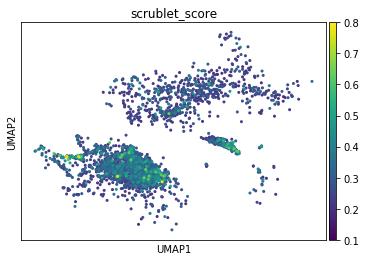

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


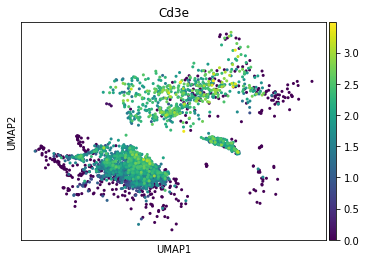

saving figure to file 2020-04-09 /umapScrublet non doublets Umap.pdf


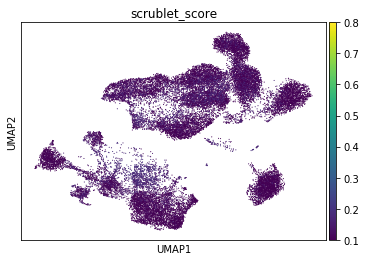

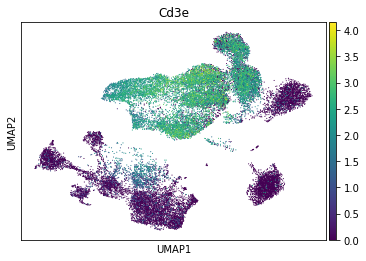

saving figure to file 2020-04-09 /umapscrublet Overall_Umap.pdf


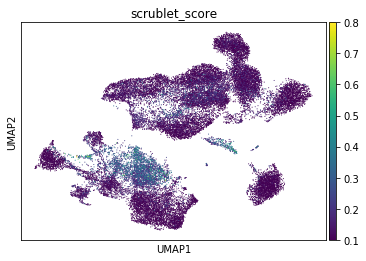

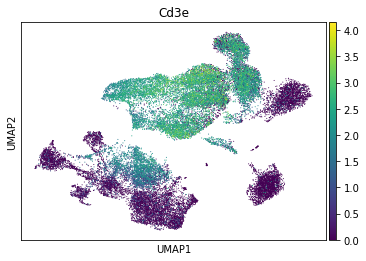

AnnData object with n_obs × n_vars = 29186 × 10363 
    obs: 'sample_num', 'n_genes', 'hk_count', 'percent_mito', 'n_counts', 'unique_gene_count', 'time_point', 'scrublet_score'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'time_point_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'


In [15]:
#sc.pl.umap(adata,color='Cd3e')
adata_doublets = adata[adata.obs['scrublet_score'] > 0.2, :]
adata_non_doublets = adata[adata.obs['scrublet_score'] <= 0.2, :]
#adata = adata[adata.obs['scrublet_score'] <= 0.2, :]
print(adata_doublets)
print(adata_non_doublets)
sc.pl.umap(adata_doublets,color='scrublet_score',vmin=.1,vmax=.8)
sc.pl.umap(adata_doublets,color='Cd3e')
sc.pl.umap(adata_non_doublets,color='scrublet_score',vmin=.1,vmax=.8,save='Scrublet non doublets Umap.pdf')
sc.pl.umap(adata_non_doublets,color='Cd3e')
sc.pl.umap(adata,color='scrublet_score',vmin=.1,vmax=.8,save='scrublet Overall_Umap.pdf')
sc.pl.umap(adata,color='Cd3e')
#sc.pl.umap(adata,color='hk_count')
print(adata)


saving figure to file 2020-04-09 /umapgene counts_Umap.pdf


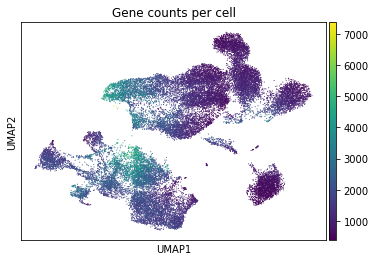

In [16]:
sc.pl.umap(adata,color=['unique_gene_count'],title='Gene counts per cell',save='gene counts_Umap.pdf')

AnnData object with n_obs × n_vars = 3266 × 10363 
    obs: 'sample_num', 'n_genes', 'hk_count', 'percent_mito', 'n_counts', 'unique_gene_count', 'time_point', 'scrublet_score'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'time_point_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'


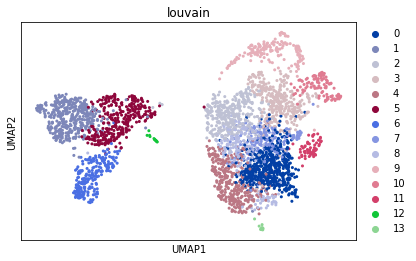

AnnData object with n_obs × n_vars = 25920 × 10363 
    obs: 'sample_num', 'n_genes', 'hk_count', 'percent_mito', 'n_counts', 'unique_gene_count', 'time_point', 'scrublet_score'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'time_point_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
saving figure to file 2020-04-09 /umapnon doublets overall_Umap.pdf


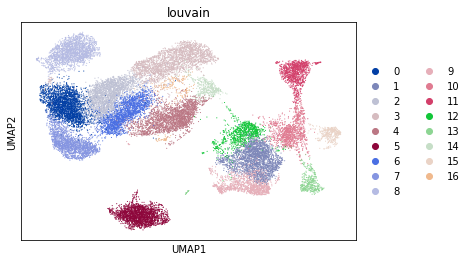

In [17]:
print(adata_doublets)
sc.tl.pca(adata_doublets, svd_solver='arpack')
sc.pp.neighbors(adata_doublets, n_neighbors=10, n_pcs = 40)
sc.tl.umap(adata_doublets)
sc.tl.louvain(adata_doublets)
sc.pl.umap(adata_doublets,color='louvain')

print(adata_non_doublets)
sc.tl.pca(adata_non_doublets, svd_solver='arpack')
sc.pp.neighbors(adata_non_doublets, n_neighbors=10, n_pcs = 40)
sc.tl.umap(adata_non_doublets)
sc.tl.louvain(adata_non_doublets)
sc.pl.umap(adata_non_doublets,color='louvain',save='non doublets overall_Umap.pdf')

In [18]:
adata_non_doublets.write("All complete filtering.h5ad")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


saving figure to file 2020-04-09 /umapcd3e overall_Umap.pdf


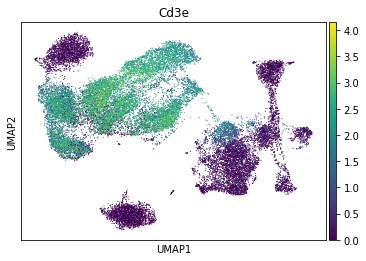

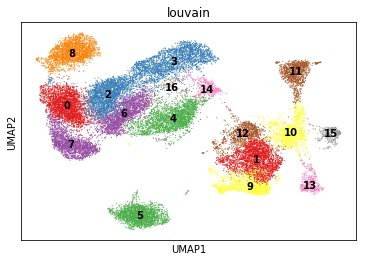

In [19]:
sc.pl.umap(adata_non_doublets,color='Cd3e',save='cd3e overall_Umap.pdf')
sc.pl.umap(adata_non_doublets,color='louvain',palette='Set1', legend_loc = "on data")

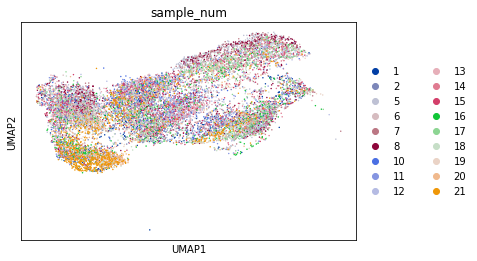

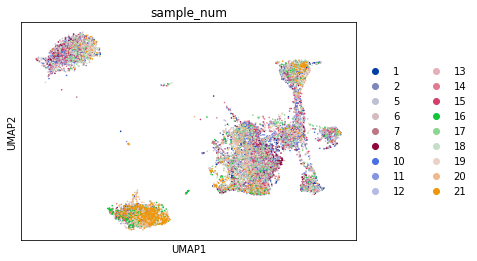

In [20]:
## b16 T cells split ##

adata_T_cells = adata_non_doublets[adata_non_doublets.obs['louvain'].isin(['0','2','3','4','6','7','14','16'])]
sc.pl.umap(adata_T_cells, color=['sample_num'])

adata_non_T_cells = adata_non_doublets[adata_non_doublets.obs['louvain'].isin(['1','5','8','9','10','11','12','13','15'])]
sc.pl.umap(adata_non_T_cells, color=['sample_num'])

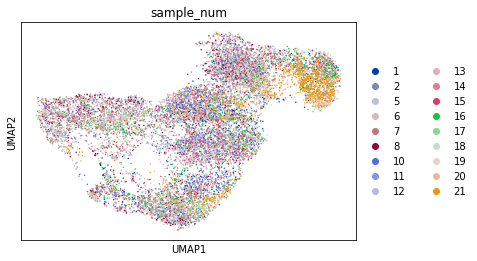

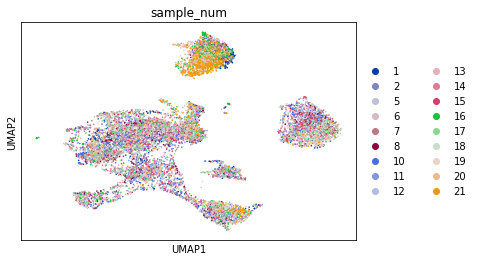

saving figure to file 2020-04-09 /umap T cell cluster umap.pdf


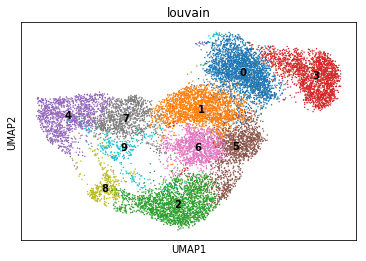

saving figure to file 2020-04-09 /umap non T cell cluster umap.pdf


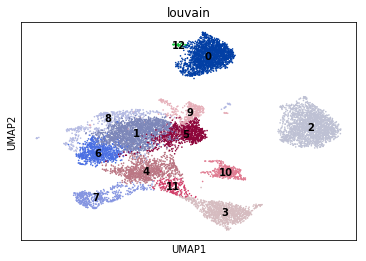

In [21]:
#Initial clustering#

sc.tl.pca(adata_T_cells, svd_solver='arpack')
sc.pp.neighbors(adata_T_cells, n_neighbors=10, n_pcs = 40)
sc.tl.umap(adata_T_cells)
sc.tl.louvain(adata_T_cells)
sc.pl.umap(adata_T_cells,color='sample_num')


sc.tl.pca(adata_non_T_cells, svd_solver='arpack')
sc.pp.neighbors(adata_non_T_cells, n_neighbors=10, n_pcs = 40)
sc.tl.umap(adata_non_T_cells)
sc.tl.louvain(adata_non_T_cells)
sc.pl.umap(adata_non_T_cells,color='sample_num')


sc.pl.umap(adata_T_cells,color=['louvain'],legend_loc = "on data", save=' T cell cluster umap.pdf')
sc.pl.umap(adata_non_T_cells,color=['louvain'],legend_loc = "on data", save=' non T cell cluster umap.pdf')



In [22]:
adata_T_cells.write(str(date.today()) + ' ' + "T cells.h5ad")
adata_non_T_cells.write(str(date.today()) + ' ' + "Non T cells.h5ad")
adata.write(str(date.today()) + ' ' + "All cells.h5ad")

In [23]:
# remove that one smallcluster from T cells that doesn't express cd3
#non_T_cell_T_cells = adata_T_cells[adata_T_cells.obs['louvain'].isin(["9"])].obs_names
#non_T_cell_T_cells

#with open('not T cell T cells.txt', 'w') as filehandle:
#    for listitem in non_T_cell_T_cells:
#        filehandle.write('%s,' % listitem)

In [24]:
# remove a cluster of malignant cells

#malignant_cells = adata_non_T_cells[adata_non_T_cells.obs['louvain'].isin(["14"])].obs_names

#with open('malignant cells 2.txt', 'w') as filehandle:
 #   for listitem in malignant_cells:
  #      filehandle.write('%s,' % listitem)


In [25]:
#make copies of the adatas, except they are counts instead of normalized
#only needs to be run once, alongside the bottom cell for topic modeling
T_cell_counts = adata_T_cells.copy()
non_T_cell_counts = adata_non_T_cells.copy()

for cell in T_cell_counts.obs_names:
    T_cell_counts[cell].X = adata_counts[cell].X
print('done T cells')
for cell in non_T_cell_counts.obs_names:
    non_T_cell_counts[cell].X = adata_counts[cell].X
print('done non T cells')
print(T_cell_counts.X)
print(non_T_cell_counts.X)
print(T_cell_counts)
print(non_T_cell_counts)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


done T cells
done non T cells
[[1. 0. 2. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
AnnData object with n_obs × n_vars = 14142 × 10363 
    obs: 'sample_num', 'n_genes', 'hk_count', 'percent_mito', 'n_counts', 'unique_gene_count', 'time_point', 'scrublet_score', 'louvain'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'time_point_colors', 'louvain', 'louvain_colors', 'sample_num_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
AnnData object with n_obs × n_vars = 11778 × 10363 
    obs: 'sample_num', 'n_genes', 'hk_count', 'percent_mito', 'n_counts', 'unique_gene_count', 'time_point', 'scrublet_score', 'louvain'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'time_point_colors', 'louvain', 'louvain_colors', 'sample_num_colors'


In [26]:
T_cell_counts.write(str(date.today()) + ' ' + "T cell counts.h5ad")
non_T_cell_counts.write(str(date.today()) + ' ' + "Non T cell counts.h5ad")
adata_counts.write(str(date.today()) + ' ' + "All cells counts.h5ad")

... storing 'sample_num' as categorical
